In [1]:
from qiskit.algorithms import VQE
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from qiskit_optimization.converters import QuadraticProgramToQubo
from typing import List
from itertools import permutations
from qiskit import IBMQ
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
# useful additional packages
from qiskit.optimization.applications.ising.docplex import get_operator
import networkx as nx
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.problems import QuadraticProgram
from qiskit import Aer
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info.operators import SparsePauliOp 


In [3]:
class FSPasTSP:
     """Quantum Optimization for the FSP by mapping it to FSP"""
     def __init__(self,numberMachine : int,procTime:List[List[int]],numberJobs : int,approach : int)-> None :
        """
        Args :
        timeSpan : the makespan value
        numberMachine : machine number
        numverJobs : job's number
        """
        self.numberMachine = numberMachine
        self.numberJobs = numberJobs
        self.procTime = procTime
        self.approach = approach

     def convert_FSP_WH(self) -> dict:
         """
             We are using Widemar & Hertz approach
             duv=p1,u + \sum_2^m (m-i)|pi,u - pi-1,v| + pmv
         """
         TspInstance={
             (u,v) :
             self.procTime[1][u]
             +self.procTime[self.numberMachine-1][v]
             +sum([(self.numberMachine-i)*abs(self.procTime[i][u]-self.procTime[i-1][v]) for i in range(1,self.numberMachine)])
             for u in range(self.numberJobs)
             for v in range(self.numberJobs)
             if u!=v
             }
         return TspInstance

     def convert_FSP_SS6(self) -> dict:
         TspInstance={
             (u,v):
             sum([max(self.procTime[i][u]-self.procTime[i-1][v],0)+2*abs(min(self.procTime[i][u]-self.procTime[i-1][v],0)) for i in range(1,self.numberMachine)])
             for u in range(self.numberJobs)
             for v in range(self.numberJobs)
             if u!=v
             }
         return TspInstance

     def convert_FSP_Gupta(self) -> dict:
         def CT_j (u,v,j) -> int :
             ct = 0
             if j == 0 : return ct
             ct = max( CT_j(u,v,j-1) , sum([self.procTime[i][v] for i in range(j)]) )
             return ct

         TspInstance = {
            (u,v) :
            CT_j(u,v,self.numberMachine) - sum([self.procTime[i][u] for i in range(self.numberMachine)])
            for u in range(self.numberJobs)
            for v in range(self.numberJobs)
            if u != v
         }
         return TspInstance

     def convert_FSP_Moccelin(self) -> dict:
          def UBX (u,v,m) -> int:
              ubx = 0
              if m == 0 : return ubx
              ubx = max (0, UBX(u,v,m-1) + self.procTime[m-1][u] - self.procTime[m][u])
              return ubx
          TspInstance = {
            (u,v) :
            UBX(u,v,self.numberMachine-1) - sum([self.procTime[i][u] for i in range(self.numberMachine)])
            for u in range(self.numberJobs)
            for v in range(self.numberJobs)
            if u != v
         }
          return TspInstance
     
     def convert_FSP_SS1(self) -> dict:
         TspInstance = {
            (u,v) :
            sum([abs(self.procTime[i][u]-self.procTime[i-1][v]) for i in range(1,self.numberMachine)])
            for u in range(self.numberJobs)
            for v in range(self.numberJobs)
            if u != v
         }
         return TspInstance
     
     def quadratic_program(self)->QuadraticProgram:
         """
         approach :
           - 1 : convert_FSP_WH()
           - 2 : convert_FSP_SS6()
           - 3 : convert_FSP_Gupta()
           - 4 : convert_FSP_Moccelin() 
           - 5 :  convert_FSP_SS1()
         """
         approach = self.approach
         if approach == 1 : TspIns=self.convert_FSP_WH()
         elif approach == 2 : TspIns=self.convert_FSP_SS6()
         elif approach == 3 : TspIns = self.convert_FSP_Gupta()
         elif approach == 4 : TspIns = self.convert_FSP_Moccelin()
         elif approach == 5 : TspIns = self.convert_FSP_SS1()
         mdl=Model(name="TSP")
         n=self.numberJobs
         x = {(i, k): mdl.binary_var(name=f"x_{i}_{k}") for i in range(n) for k in range(n)}
         cost_fun=mdl.sum(
             TspIns[(u,v)]* x[(u, k)] * x[(v, (k + 1) % n)]
             for u in range(n)
             for v in range(n)
             for k in range(n)
             if u != v
         )
         mdl.minimize(cost_fun)
         for u in range(n):
            mdl.add_constraint(mdl.sum(x[(u, k)] for k in range(n)) == 1)
         for k in range(n):
            mdl.add_constraint(mdl.sum(x[(u, k)] for u in range(n)) == 1)
         op = from_docplex_mp(mdl)
         return op
     
     def draw(self):
          instance = self.convert_FSP_WH()
          edges = [(u,v) for u,v in instance.keys()]
          graph = nx.DiGraph()
          graph.add_nodes_from([i for i in range(self.numberJobs)])
          graph.add_weighted_edges_from(
              [(u,v,instance[(u,v)])
              for u,v in edges]
              )
          pos = nx.spring_layout(graph, seed=6)
          weight_labels = nx.get_edge_attributes(graph,'weight')
          nx.draw(graph,pos,font_color = 'white', node_shape = 's', with_labels = True,)
          nx.draw_networkx_edge_labels(graph,pos,edge_labels=weight_labels)
          return graph

     def to_QUBO(self)->QuadraticProgram :
         conv = QuadraticProgramToQubo()
         return conv.convert(self.quadratic_program())

     def to_Ising(self)  :
         """
         qubitOp:Hamiltonian operator, offset: constant
         """
         qubitOp, offset = self.to_QUBO().to_ising()
         return qubitOp, offset
     
     def brute_force(self) :
         approach =self.approach
         if approach == 1 : tsp=self.convert_FSP_WH()
         elif approach == 2 : tsp =self.convert_FSP_SS6()
         elif approach == 3 : tsp = self.convert_FSP_Gupta()
         elif approach == 4 : tsp = self.convert_FSP_Moccelin()
         elif approach == 5 : tsp = self.convert_FSP_SS1()
         a =list(permutations(range(1,self.numberJobs)))
         last_best_distance = 1e10
         for i in a :
                distance = 0
                pre_j = 0
                for j in i:
                    if (pre_j != 0) : distance = distance + tsp[( pre_j,j)]
                    pre_j = j
                distance = distance + tsp[(0,pre_j)]
                order = (0,) + i
                if distance < last_best_distance:
                    best_order = order
                    last_best_distance = distance
         return last_best_distance, best_order
     
   



class VariationalSolver():
    def __init__(self, 
        forme : int,
        method : int , 
        quantumInstance :  QuantumInstance , 
        data : str,            
        )->None:
        
        """
         Different approach to solve QUBO
            Forme : TimeIndex form, Tsp Forme, PositionIndex
            method : Which method to be used VQE,QAOA,XY-QAOA,...
            quantumInstance : Backend to execute the circuit
            data : Instance pathe

        """
        self.forme = forme,
        self.method = method
        self.quantumInstance = quantumInstance
        self.data = data
        
    def read_Data(self) ->dict :
        Instance,l,M = {},[],[]
        i,p,c = 0,0,''
        file = open(self.data,"r")
        ins = file.read().split()
        while i in range(len(ins)):
            n = int(ins[i])
            m = int(ins[i+1])
            for k in range(i+2,i+m+2):
                for j in range(len(ins[k])) :
                    if ins[k][j] == ',' : 
                        l.append(int(c))
                        c=''
                    else : c += ins[k][j] 
                M.append(l)
                l= []
            Instance[p]=(n,m),M
            M = []
            i = i + m +2 
            p +=1
        return Instance
      
    def VQE(self,operator, device):
        #operator,offeset = problem.to_Ising()
        ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
        spsa = SPSA(maxiter=1000)
        vqe = VQE(ansatz, optimizer=spsa, quantum_instance=device)
        result = vqe.compute_minimum_eigenvalue(operator)
        print(result)
        optimizer_evals = result.optimizer_evals
        return optimizer_evals
    
    def QAOA(self,operator,device):
        
        return 0


numIter = 1
numShots = 1024
initialPoint = 40

#IBMQ.load_account()
       
#my_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
        
#fsp = FSPasTSP(2,[[3,5,4,1],[1,5,4,2]],4)
#distance,order = fsp.brute_force()
#op,off=fsp.to_Ising()
seed =50
#device = QuantumInstance(Aer.get_backend('aer_simulator'), seed_transpiler=seed, seed_simulator=seed)
from qiskit.providers.aer import QasmSimulator
device = QuantumInstance(QasmSimulator(method='matrix_product_state'), shots=300)

vqa_Solver = VariationalSolver(1,1,device,'instance.txt')
instances = vqa_Solver.read_Data()
"""
for key,value in instances.items():
    for i in range(1,2):
        fsp = FSPasTSP(value[0][1],value[1],value[0][0],i)
        distance,order = fsp.brute_force()
        op,off = fsp.to_Ising()
        vqa_result = vqa_Solver.VQE(op,device)  
        print(value)
        print(vqa_result)
        print(distance,order)
        print('-------------------------')
"""      


"\nfor key,value in instances.items():\n    for i in range(1,2):\n        fsp = FSPasTSP(value[0][1],value[1],value[0][0],i)\n        distance,order = fsp.brute_force()\n        op,off = fsp.to_Ising()\n        vqa_result = vqa_Solver.VQE(op,device)  \n        print(value)\n        print(vqa_result)\n        print(distance,order)\n        print('-------------------------')\n"

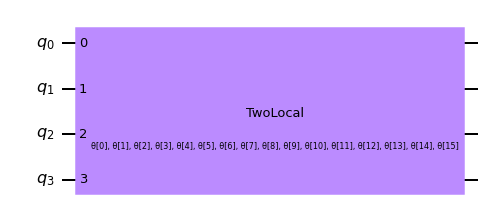

In [11]:
from qiskit.circuit.library import TwoLocal
ansatz = TwoLocal(4,rotation_blocks='ry', entanglement_blocks='cz')
ansatz.draw('mpl')